In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Genre Classification

In [0]:
import os

In [4]:
os.listdir(os.getcwd())

['.config', 'gdrive', 'sample_data']

In [0]:
# get the list of genres
genres = os.listdir('/content/gdrive/My Drive/Colab Notebooks/genres_original')

In [6]:
data = []


for genre in genres:
  for song in os.listdir(f'/content/gdrive/My Drive/Colab Notebooks/genres_original/{genre}'):
    x, sr = librosa.load(f'/content/gdrive/My Drive/Colab Notebooks/genres_original/{genre}/{song}')

    # features  
    chroma_stft = librosa.feature.chroma_stft(x, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(x, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(x, sr=sr)
    spec_roff = librosa.feature.spectral_rolloff(x, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(x)

    # get the mean of the features
    data.append({'name':song,
                 'chroma':np.mean(chroma_stft),
                 'centroid':np.mean(spec_cent),
                 'bandwidth':np.mean(spec_bw),
                 'rolloff':np.mean(spec_roff),
                 'zero-crossing rate':np.mean(zcr),
                 'type':genre})
    

data = pd.DataFrame(data)

data.head()

,name,chroma,centroid,bandwidth,rolloff,zero-crossing rate,type
0,pop.00003.wav,0.409812,1836.956691,2066.669705,3670.803274,0.085323,pop
1,pop.00001.wav,0.412993,3702.105111,3431.856264,8072.977711,0.149394,pop
2,pop.00000.wav,0.389631,3421.887738,3409.775605,7952.938014,0.126720,pop
3,pop.00002.wav,0.417771,3214.086840,3269.678966,7424.433605,0.118866,pop
4,pop.00004.wav,0.384296,2753.120791,2861.501507,5986.680118,0.123709,pop


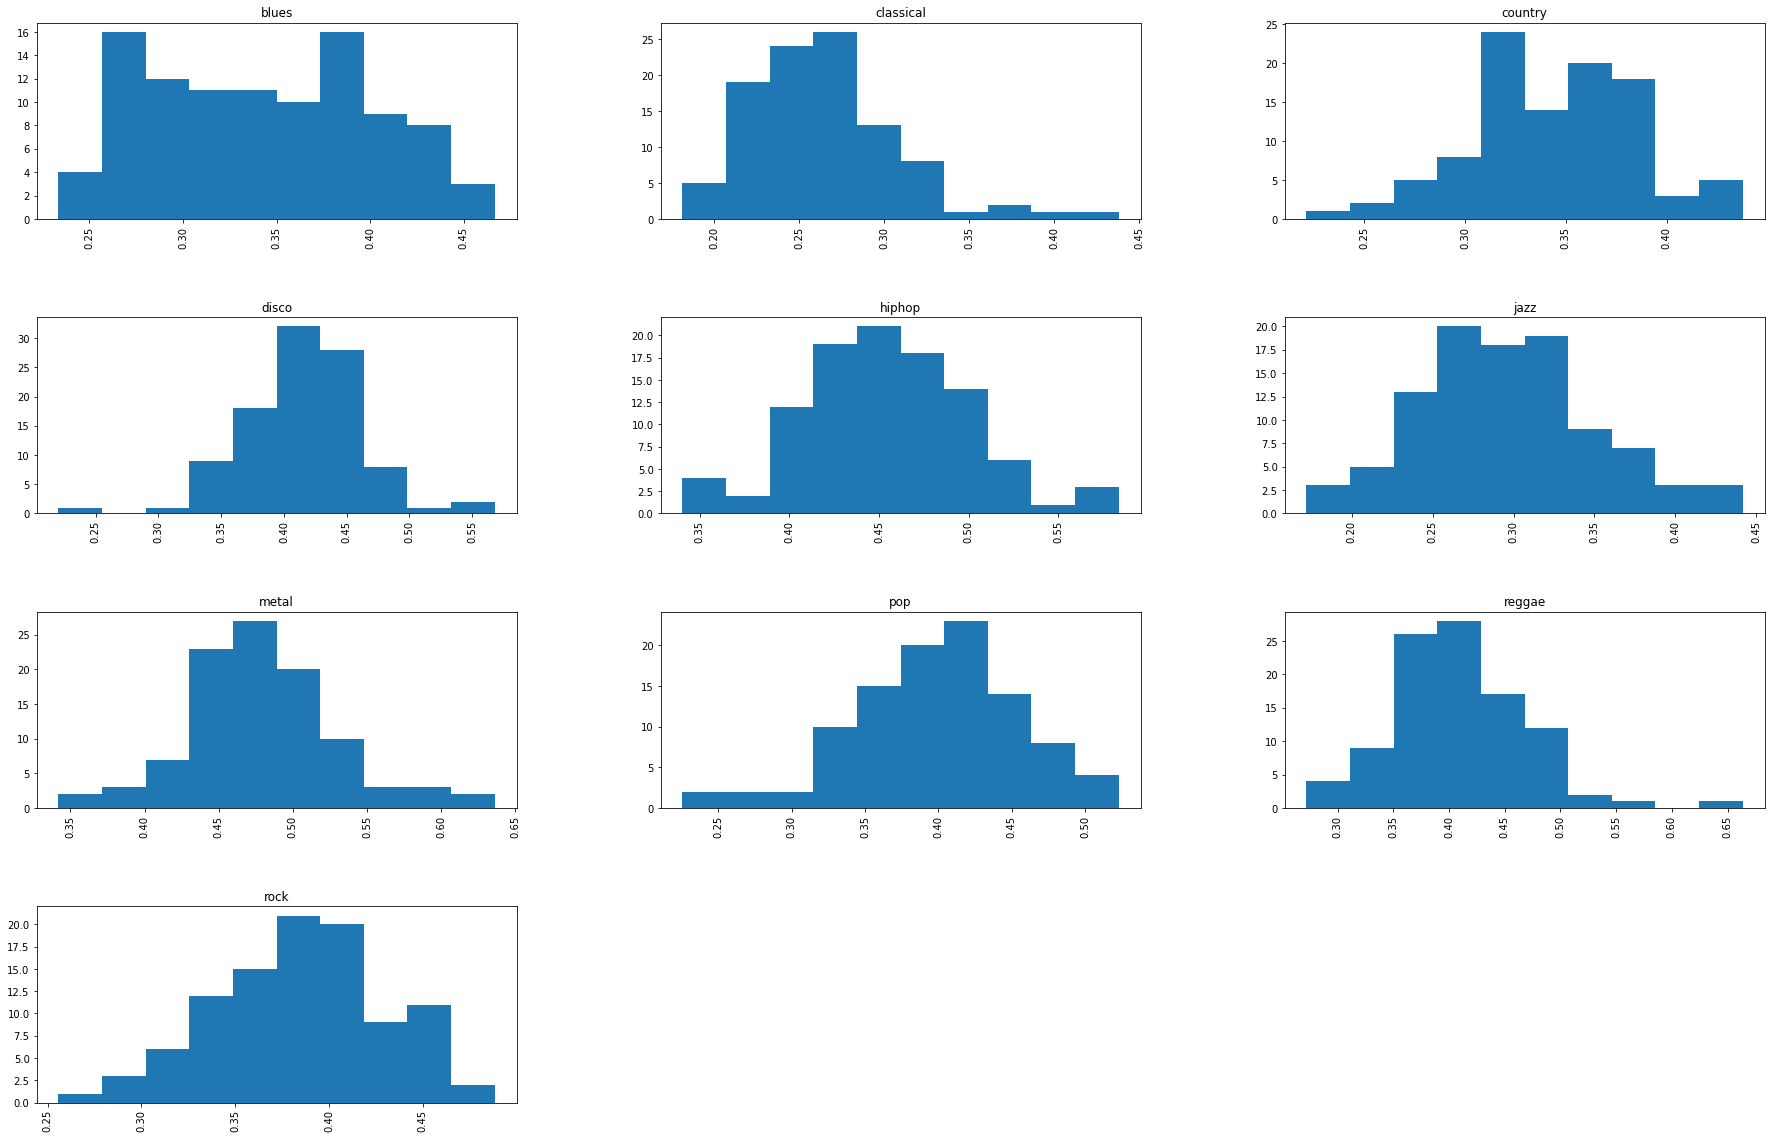

In [8]:
data.hist(column='chroma', by='type',figsize=(30,20))
plt.show()

#### Encode Label

In [0]:
from sklearn import preprocessing

In [0]:
le = preprocessing.LabelEncoder()

In [0]:
labels = data['type']

y = le.fit_transform(labels)

#### Split Data

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
features = data.drop(['name','type'],axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.3,random_state=101)

#### Scale Data

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

#### Model: Keras 

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [391]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=500,
          batch_size=128,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/500
6/6 [==============================] - 0s 27ms/step - loss: 2.3210 - accuracy: 0.0914 - val_loss: 2.3020 - val_accuracy: 0.1033
Epoch 2/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2992 - accuracy: 0.1114 - val_loss: 2.2982 - val_accuracy: 0.0933
Epoch 3/500
6/6 [==============================] - 0s 12ms/step - loss: 2.3013 - accuracy: 0.0914 - val_loss: 2.2973 - val_accuracy: 0.0933
Epoch 4/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2809 - accuracy: 0.1157 - val_loss: 2.2960 - val_accuracy: 0.1067
Epoch 5/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2905 - accuracy: 0.1014 - val_loss: 2.2946 - val_accuracy: 0.1533
Epoch 6/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2814 - accuracy: 0.1243 - val_loss: 2.2919 - val_accuracy: 0.1533
Epoch 7/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2762 - accuracy: 0.1029 - val_loss: 2.2879 - val_accuracy: 0.1600
Epoch 8/500
6/6 [===

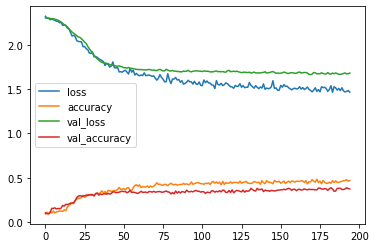

In [392]:
model_loss = pd.DataFrame(model.history.history)

model_loss.plot()

###### Prediction

In [0]:
predictions = model.predict_classes(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [395]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.60      0.07      0.13        40
           1       0.83      0.81      0.82        37
           2       0.18      0.23      0.21        30
           3       0.29      0.07      0.11        30
           4       0.24      0.17      0.20        29
           5       0.34      0.38      0.36        32
           6       0.53      0.71      0.61        28
           7       0.34      0.67      0.45        24
           8       0.27      0.31      0.29        26
           9       0.21      0.38      0.27        24

    accuracy                           0.37       300
   macro avg       0.38      0.38      0.34       300
weighted avg       0.41      0.37      0.35       300



In [396]:
print(confusion_matrix(y_test,predictions))

[[ 3  1  6  0  1 12  1  0  7  9]
 [ 0 30  3  0  0  1  0  0  2  1]
 [ 2  0  7  0  0  8  0  8  0  5]
 [ 0  0  2  2  3  0  6  5  2 10]
 [ 0  0  0  2  5  0  6  7  7  2]
 [ 0  5  8  0  0 12  1  6  0  0]
 [ 0  0  0  0  4  0 20  0  0  4]
 [ 0  0  2  2  0  2  0 16  2  0]
 [ 0  0  4  0  7  0  2  2  8  3]
 [ 0  0  6  1  1  0  2  3  2  9]]


#### Model: Randomize the Dataframe

In [0]:
# randomize the rows
from sklearn.utils import shuffle

In [398]:
ran_data = shuffle(data)

ran_data.head()

,name,chroma,centroid,bandwidth,rolloff,zero-crossing rate,type
923,country.00022.wav,0.321503,1719.309237,2142.286763,3449.400977,0.068057,country
879,classical.00078.wav,0.225150,715.399707,1030.415264,1037.798803,0.041282,classical
491,disco.00094.wav,0.416821,2207.386073,2353.334092,5074.017037,0.093556,disco
746,reggae.00048.wav,0.390177,2672.851913,2549.790518,5607.942217,0.111168,reggae
594,rock.00094.wav,0.389313,2628.863788,2210.478936,5085.874454,0.146649,rock


In [0]:
# encode labels
y_ran = ran_data['type']

y_ran = le.fit_transform(y_ran)

In [0]:
x_ran = ran_data.drop(['name','type'],axis=1)

In [0]:
# split 
X_train_ran, X_test_ran, y_train_ran, y_test_ran = train_test_split(x_ran,y_ran,test_size=0.3,random_state=101)

In [0]:
# scale 
X_train_ran = scaler.fit_transform(X_train_ran)

X_test_ran = scaler.transform(X_test_ran)

In [0]:
# build model
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(X_train_ran.shape[1],)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [405]:
model.fit(x=X_train_ran, 
          y=y_train_ran, 
          epochs=500,
          batch_size=128,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/500
6/6 [==============================] - 0s 25ms/step - loss: 2.3104 - accuracy: 0.1000 - val_loss: 2.2999 - val_accuracy: 0.0833
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 2.3008 - accuracy: 0.0743 - val_loss: 2.2964 - val_accuracy: 0.0800
Epoch 3/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2919 - accuracy: 0.0971 - val_loss: 2.2921 - val_accuracy: 0.0800
Epoch 4/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2773 - accuracy: 0.1114 - val_loss: 2.2884 - val_accuracy: 0.0800
Epoch 5/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2718 - accuracy: 0.1157 - val_loss: 2.2841 - val_accuracy: 0.0867
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2636 - accuracy: 0.1029 - val_loss: 2.2784 - val_accuracy: 0.0933
Epoch 7/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2546 - accuracy: 0.1214 - val_loss: 2.2705 - val_accuracy: 0.1000
Epoch 8/500
6/6 [===

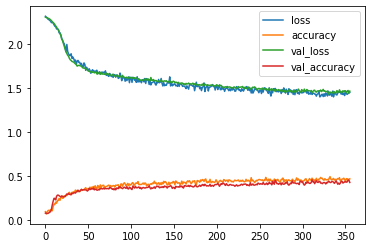

In [406]:
# evaluate
model_loss = pd.DataFrame(model.history.history)

model_loss.plot()

In [0]:
# predict
predictions = model.predict_classes(X_test_ran)

In [408]:
print(classification_report(y_test_ran,predictions))

              precision    recall  f1-score   support

           0       0.50      0.29      0.37        34
           1       0.65      0.91      0.76        33
           2       0.36      0.27      0.31        33
           3       0.31      0.43      0.36        21
           4       0.52      0.38      0.44        32
           5       0.46      0.42      0.44        38
           6       0.63      0.63      0.63        27
           7       0.36      0.69      0.47        26
           8       0.38      0.32      0.35        28
           9       0.43      0.32      0.37        28

    accuracy                           0.46       300
   macro avg       0.46      0.47      0.45       300
weighted avg       0.47      0.46      0.45       300



In [409]:
print(confusion_matrix(y_test_ran,predictions))

[[10  3  6  4  0  4  2  0  2  3]
 [ 1 30  1  1  0  0  0  0  0  0]
 [ 3  3  9  1  0  8  0  6  1  2]
 [ 0  0  1  9  2  0  3  3  1  2]
 [ 0  1  0  3 12  0  2  6  7  1]
 [ 5  7  2  0  0 16  0  8  0  0]
 [ 0  0  1  3  4  0 17  0  0  2]
 [ 0  0  0  1  0  5  0 18  2  0]
 [ 1  2  2  1  4  0  2  5  9  2]
 [ 0  0  3  6  1  2  1  4  2  9]]


#### Model: KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)

In [412]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
pred = knn.predict(X_test)

In [414]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.44      0.35      0.39        40
           1       0.77      0.73      0.75        37
           2       0.20      0.17      0.18        30
           3       0.19      0.13      0.16        30
           4       0.27      0.24      0.25        29
           5       0.49      0.53      0.51        32
           6       0.54      0.54      0.54        28
           7       0.56      0.42      0.48        24
           8       0.28      0.42      0.34        26
           9       0.12      0.21      0.15        24

    accuracy                           0.38       300
   macro avg       0.38      0.37      0.37       300
weighted avg       0.40      0.38      0.39       300



In [415]:
print(confusion_matrix(y_test,pred))

[[14  3  5  4  0  4  0  0  3  7]
 [ 3 27  3  0  0  2  0  0  0  2]
 [ 2  2  5  2  1  8  0  1  5  4]
 [ 4  0  5  4  4  0  6  1  0  6]
 [ 1  0  0  4  7  0  3  2  6  6]
 [ 1  2  0  0  0 17  1  1  6  4]
 [ 1  0  0  2  6  0 15  0  2  2]
 [ 0  0  4  1  3  0  0 10  4  2]
 [ 2  0  0  1  4  2  2  1 11  3]
 [ 4  1  3  3  1  2  1  2  2  5]]


In [0]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

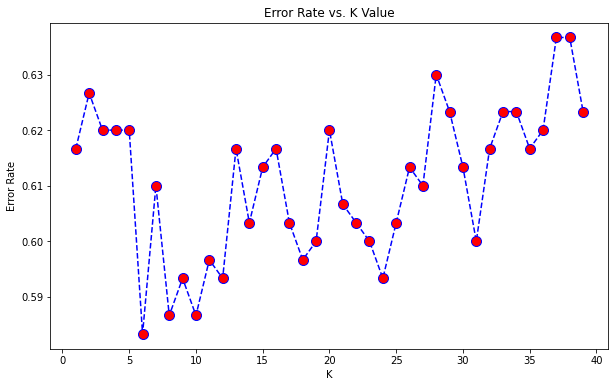

In [417]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [418]:
# NOW WITH K=6
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=6')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=6


[[18  3  7  0  1  2  0  0  5  4]
 [ 4 28  1  0  0  3  0  0  1  0]
 [ 3  1  7  2  2 12  0  1  2  0]
 [ 2  0  4 10  3  0  5  2  1  3]
 [ 1  0  3  3  8  1  4  3  4  2]
 [ 3  7  5  1  0 10  1  4  1  0]
 [ 0  0  3  3  3  0 16  0  1  2]
 [ 0  0  3  2  3  1  0 11  3  1]
 [ 0  0  3  0  7  0  1  0 12  3]
 [ 3  0  3  4  2  2  1  2  2  5]]


              precision    recall  f1-score   support

           0       0.53      0.45      0.49        40
           1       0.72      0.76      0.74        37
           2       0.18      0.23      0.20        30
           3       0.40      0.33      0.36        30
           4       0.28      0.28      0.28        29
           5       0.32      0.31      0.32        32
           6       0.57      0.57      0.57        28
           7       0.48      0.46      0.47        24
           8       0.38      0.46      0.41        26
           9       0.25      0.21      0.23        24

    accuracy                           0.42       300
   mac

#### Model: SVM

In [0]:
from sklearn.svm import SVC

In [0]:
svm = SVC()

In [421]:
svm.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
pred = svm.predict(X_test)

In [423]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.10      0.18        40
           1       0.68      0.81      0.74        37
           2       0.24      0.30      0.27        30
           3       0.36      0.17      0.23        30
           4       0.22      0.14      0.17        29
           5       0.34      0.34      0.34        32
           6       0.56      0.68      0.61        28
           7       0.38      0.62      0.47        24
           8       0.32      0.58      0.41        26
           9       0.14      0.17      0.15        24

    accuracy                           0.39       300
   macro avg       0.40      0.39      0.36       300
weighted avg       0.43      0.39      0.36       300



In [424]:
print(confusion_matrix(y_test,pred))

[[ 4  5  7  0  1  9  0  0  5  9]
 [ 1 30  4  0  0  2  0  0  0  0]
 [ 0  1  9  1  0  8  0  5  4  2]
 [ 0  0  0  5  3  0  6  4  3  9]
 [ 0  0  0  1  4  0  6  6 11  1]
 [ 0  8  6  0  0 11  1  6  0  0]
 [ 0  0  0  1  3  0 19  0  2  3]
 [ 0  0  1  1  2  2  0 15  3  0]
 [ 0  0  3  1  4  0  1  1 15  1]
 [ 0  0  7  4  1  0  1  3  4  4]]
